# **TP - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema  - Circuito**

In [3]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

In [4]:
def circuit_generator(I,Alpha):
    num_xors = random.randint(0,I)
    num_nots = random.randint(0,I)
    num_ors = random.randint(0,I)
    num_ands = int((num_xors + num_nots + num_ors) * Alpha / (1-Alpha))
    G = nx.DiGraph()
    total = 0
    
    for n in range(I):
        G.add_node(n,type="INPUT",val=None,color=1)
    
    total += I
    
    for n in range(num_xors):
        G.add_node(total+n,type="XOR",color=2)
    
    total += num_xors
    
    for n in range(num_nots):
        G.add_node(total+n,type="NOT",color=3)
    
    total += num_nots
    
    
    for n in range(num_ors):
        G.add_node(total+n,type="OR",color=4)
    
    total += num_ors
    
    for n in range(num_ands):
        G.add_node(total+n,type="AND",color=5)
    
    total+= num_ands
    
    num_gates = total - I
    
    for n in range(num_gates):
        G.add_node(total+n,type="WIRE",val=None,color=6)
    
    gates = [n for n in G.nodes() if G.nodes[n]['type'] != 'INPUT' and G.nodes[n]['type'] != 'WIRE']
    wires = [n for n in G.nodes() if G.nodes[n]['type'] == 'WIRE']
    random.shuffle(gates)
    gates_info = {}
    
    for edge in zip(gates,wires):
        G.add_edge(*edge)
        gates_info[edge[0]] = {'type':G.nodes[edge[0]]['type'] ,'output':edge[1],'level':float('inf')}
    
    output = random.choice(gates)
    G.nodes[gates_info[output]['output']]['type'] = 'OUTPUT'
    gates_info[output]['level'] = 1
    orla = [output]
    while orla:
        x = orla.pop(0)
        candidates = [g for g in gates_info if gates_info[g]['level'] > gates_info[x]['level']]
        if candidates:
            random.shuffle(candidates)
            if gates_info[x]['type'] == 'NOT':
                selected = candidates.pop(0)
                gates_info[selected]['level'] = gates_info[x]['level'] +1 
                G.add_edge(gates_info[selected]['output'],x)
                orla.append(selected)
            elif len(candidates)>1:
                for i in range(random.randint(2,len(candidates))):
                    selected = candidates.pop(0)
                    gates_info[selected]['level'] = gates_info[x]['level'] +1 
                    G.add_edge(gates_info[selected]['output'],x)
                    orla.append(selected)

            
        
    unconected = [n for n in gates if G.out_degree[gates_info[n]['output']] == 0 and G.nodes[gates_info[n]['output']]['type']!= 'OUTPUT']
    for x in unconected:
        candidates = [n for n in gates if n not in unconected and G.nodes[n]['type'] != 'NOT']
        selected = random.choice(candidates)
        G.add_edge(gates_info[x]['output'],selected)
    
    unconected = [n for n in gates if G.in_degree[n] == 0]
    
    for x in unconected:
        candidates = [i for i in G.nodes() if G.nodes[i]['type'] == 'INPUT']
        random.shuffle(candidates)
        if gates_info[x]['type'] == 'NOT':
            selected = candidates.pop(0)
            G.add_edge(selected,x)
        else:
            for i in range(random.randint(1,len(candidates))):
                selected = candidates.pop(0)
                G.add_edge(selected,x)
    
    unconected = [n for n in gates if G.in_degree[n] == 1 and (G.nodes[n]['type'] == 'OR' or G.nodes[n]['type'] == 'XOR' or G.nodes[n]['type'] == 'AND')]
    for x in unconected:   
        candidates = [i for i in G.nodes() if G.nodes[i]['type'] == 'INPUT' and (i,x) not in G.edges()]
        selected = random.choice(candidates)
        G.add_edge(selected,x)
        
    
    unconected = [n for n in G if G.nodes[n]['type'] == 'INPUT' and G.out_degree(n) == 0]
    for x in unconected:
        candidates = [i for i in gates if G.nodes[i]['type'] != 'NOT']
        selected = random.choice(candidates)
        G.add_edge(x,selected)
    
    
    
    
      
        
    return G
    
    

0 INPUT
1 INPUT
2 NOT
3 OR
4 AND
5 OUTPUT
6 WIRE
7 WIRE


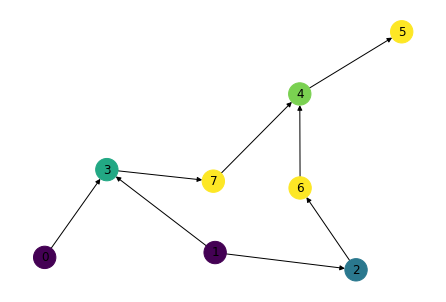

In [44]:
G = circuit_generator(2,0.4)
nx.draw(G, with_labels = True, node_size=500, node_color=[G.nodes[n]['color'] for n in G])
for g in G:
    print(g,G.nodes[g]['type'])

In [37]:
def add_restrictions(G):
    G = G.reverse()
    solver = pywraplp.Solver.CreateSolver('SCIP')
    variables = [n for n in G.nodes() if G.nodes[n]['type']=='INPUT' or G.nodes[n]['type']=='WIRE' or G.nodes[n]['type']=='OUTPUT']
    X = {}
    for n in variables:
        X[n] = solver.BoolVar(str(n))
    wires = [n for n in G if G.nodes[n]['type']=='WIRE' or G.nodes[n]['type']=='OUTPUT']
    for n in wires:
        father = list(G.neighbors(n)).pop()
        father_input = list(G.neighbors(father))
        if G.nodes[father]['type'] == "OR":
            solver.Add(sum([X[i] for i in father_input]) >= X[n])
            for i in father_input:
                solver.Add(X[n] >= X[i])
        elif G.nodes[father]['type'] == "AND":
            solver.Add(sum([X[i] for i in father_input]) <= X[n] + len(father_input) -1)
            for i in father_input:
                solver.Add(X[n] <= X[i])
        elif G.nodes[father]['type'] == "NOT":
            solver.Add(X[n] == 1 - X[father_input[0]])
        elif G.nodes[father]['type'] == "XOR":
            T = solver.IntVar(0,solver.infinity(),"XOR"+str(father))
            solver.Add(X[n] == sum([X[i] for i in father_input]) - 2*T)
    return solver, X
        
            
            
        
    

In [39]:
def calculate_input(G):
    solver,X = add_restrictions(G)
    output = [n for n in G if G.nodes[n]['type'] == 'OUTPUT'].pop()
    inputs = [n for n in G if G.nodes[n]['type'] == 'INPUT']
    solver.Add(X[output] == 1)
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        result = [round(X[i].solution_value()) for i in inputs]
        return result
    else:
        print("Sem Solução")
        return None
    
    

In [45]:
calculate_input(G)

[1, 0]